# **Ideal Readout Time**
By Jeff Ahlers 4/20/24
## Introduction
Consider an idealized ESR peak (NV center) with Lorentzian form:

$$
\text{Lorentzian Form: }L(f)=\frac{A}{1+(\frac{f-f_0}{g})^2}
$$
$$
\text{Observed PL (NV Center): }P(f)=L(f)+H=\frac{A}{1+(\frac{f-f_0}{g})^2}+H
$$

Where P has units of Counts or Counts/Sec, A has matching units (Signal), $f$ & $f_0$ have units Hz, $g$ has units Hz (Linewidth), and finally H is the background with matching units to P.

For an NV center, A is negative.

**A Note:** P, A, & H are fully equivalent when listed in Counts or in Counts/Sec (where Counts/Sec is calculated as $\frac{P(f)}{r}$ were $r$ is the readout time).

Since we have very, very good clocks, $\sigma_{r}\ll\sigma_{P(f)}$ and thus $\sigma_{\frac{P(f)}{r}}=\sigma_{P(f)}$. Going forward, I will be using Counts as my units of choice (due to the directness of calculating shot noise), but any conclusions should hold in either framework.

# The Signal

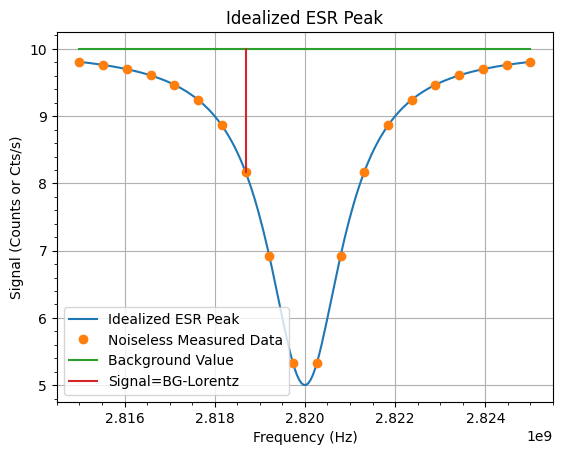

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def ideal_lorentz(f,f_0,A,g,H):
    result = A/(1+((f-f_0)/g)**2)+H
    return result

A=-5
H=10
f_0=2.87*10**9
Zeeman=50*10**6
g=1*10**6

fArray=np.linspace(f_0-Zeeman-5*g,f_0-Zeeman+5*g,200)
PLArray= ideal_lorentz(fArray,f_0-Zeeman,A,g,H)
plt.plot(fArray,PLArray)

fArrayCoarse=np.linspace(f_0-Zeeman-5*g,f_0-Zeeman+5*g,20)
PLArrayCoarse= ideal_lorentz(fArrayCoarse,f_0-Zeeman,A,g,H)
plt.plot(fArrayCoarse,PLArrayCoarse,'o')

BG_line=np.full_like(fArray,H)
plt.plot(fArray,BG_line)

f_forAline=[fArrayCoarse[7],fArrayCoarse[7]]
PL_Aline=[ideal_lorentz(fArrayCoarse[7],f_0-Zeeman,A,g,H),H]
plt.plot(f_forAline,PL_Aline)

plt.title("Idealized ESR Peak")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal (Counts or Cts/s)")
plt.grid()
plt.minorticks_on()
plt.legend(["Idealized ESR Peak","Noiseless Measured Data","Background Value","Signal=BG-Lorentz"])
plt.show()


The red line, $\color{red}{\text{our signal}}$, is the difference in counts between the bright background state and dark signal state. Our ultimate goal in ODMR is to determine the center frequency; All things being equal, the **SNR** (per spectrum measurement) is maximized when we maximize the **SNR** of each individual $\color{orange}{\text{orange data point}}$.
$$
\text{Signal: } S(f)=P(f)-H=-1*L(f)
$$
Now to introduce a dependance on readout time, $r$.
### Counts for Bright vs Dark State:
![title](./readout.png)

If you were to take the difference of the $\color{red}{\text{red}}$ & $\color{blue}{\text{blue}}$ curves, this would give you the incremental signal counts for a value of $r$. Essentially, that difference would be: $\frac{dS}{dr}$ The integral of said curve: $S(f)_{\{r\}}=\int_0^r\frac{dS}{dr}dt$ is observable.

![title](./prog_readout.png)

The sequence to observe the above is as follows:

    Signal Sequence: Initialize, Pi Pulse, Readout(tau)
    Reference Sequence: Initialize, Readout(tau)

As you can see, the total difference in counts ($\color{red}{\text{the signal}}$), grows with increasing $r$ until it asymptotically approaches the initialization time. This is natural as the initialization time is the timescale for complete loss of contrast.
For now, I will model the above curve as:
$$
S(f)_{\{r\}}=a_f(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}
$$
where a is the asymptotic value for $r \gg b$, b sets the asymptote timescale, and m sets the initial linear rise. This does not necessarily describe the NV physically, but it has reasonably similar behavior for our purposes. When $f=f_0$, then $a=A$ (little a is the contrast at some f). In actual use of these formulas for explicitly determining optimal $r$, we would fit a and b against the r dependant plot above.

We can then write out the full expression for an ESR curve:
$$
\text{Lorentzian Form: }L(f)_{\{r\}}=\frac{A_{\{r\}}}{1+(\frac{f-f_0}{g})^2}
$$
$$
A_{\{r\}}=a_{\{f_0\}}(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}} \text{  with  } A_{\{r \gg b\}}=a_{\{f_0\}}=A
$$
$$
L(f)_{\{r\}}=\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}
$$
$$
\text{Observed PL (NV Center): }P(f)_{\{r\}}=L(f)_{\{r\}}+H=\frac{S(f_0)_{\{r\}}}{1+(\frac{f-f_0}{g})^2}+H=\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}+H
$$


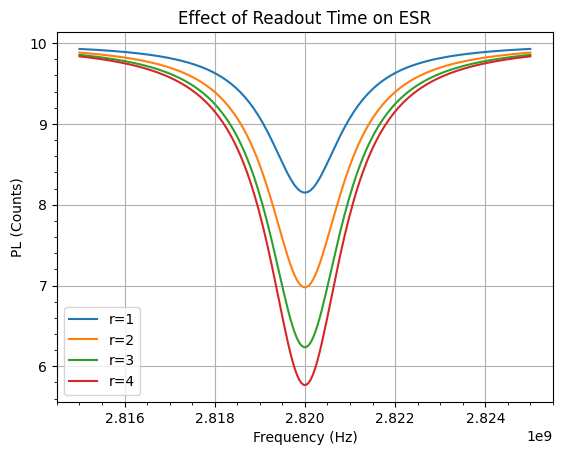

In [16]:
def signal(r,m,a,b):
    firstTerm=a*(1-np.exp(-1*r/b))
    secondTerm=m*r*np.exp(-r/b)
    result = firstTerm+secondTerm
    return result
A=-5
H=10
f_0=2.87*10**9
Zeeman=50*10**6
g=1*10**6
a=-1*A
b=a/2
m=0.3

r=np.array([1,2,3,4])

PLArray= ideal_lorentz(fArray,f_0-Zeeman,-1*signal(r[0],m,a,b),g,H)
plt.plot(fArray,PLArray)
PLArray= ideal_lorentz(fArray,f_0-Zeeman,-1*signal(r[1],m,a,b),g,H)
plt.plot(fArray,PLArray)
PLArray= ideal_lorentz(fArray,f_0-Zeeman,-1*signal(r[2],m,a,b),g,H)
plt.plot(fArray,PLArray)
PLArray= ideal_lorentz(fArray,f_0-Zeeman,-1*signal(r[3],m,a,b),g,H)
plt.plot(fArray,PLArray)
plt.title("Effect of Readout Time on ESR")
plt.legend(["r=1","r=2","r=3","r=4"])
plt.ylabel("PL (Counts)")
plt.xlabel("Frequency (Hz)")
plt.grid()
plt.minorticks_on()
plt.show()

## The Noise
As a reminder, what we care about is:
$$
\text{Signal: } S(f)_{\{r\}}=P(f)_{\{r\}}-H=-1*L(f)_{\{r\}} \text{ with associated noise: } \sigma_{S(f)_{\{r\}}}
$$

For now, we will only consider shot noise type noise that scales as $\sqrt{N}$.
The shot noise of our observed photoluminescence $P(f)$ is $\sigma_{P(f)}=\sqrt{P(f)}$. This enters the shot noise of our signal:
$$
\sigma_{S_{\{r\}}}=\sqrt{{\sigma_{P(f)_{\{r\}}}}^2+{\sigma_{{H}}}^2}=\sqrt{P(f)_{\{r\}}+H}=\sqrt{H-L(f)_{\{r\}}+H}=\sqrt{2H-L(f)_{\{r\}}}
$$
$$
\sigma_{S_{\{r\}}}=\sqrt{2H-\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}
$$


## Bring it all together: **SNR**

Finally, we must introduce a non-readout-sequence-time which we will call $q$ where the total sequence time, $T_{tot}=q+r$.


Our starting SNR per one measurement is:
$$
\frac{S(f)_{\{r\}}}{\sigma_{S_{\{r\}}}}
=\frac{-1*\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}{\sigma_{S_{\{r\}}}}
$$

Now, assuming uncorrelated noise and N measurements averaged:

$$
\sigma_{S_{\{r\}\{N\}}}
=\frac{\sqrt{N{\sigma_{S}}^2}}{N}
=\frac{\sigma_{S_{\{r\}}}}{\sqrt{N}}
$$

The average signal acquired per **N** measurements is:
$$
\frac{S(f)_{\{r\}\{N\}}}{N}=\frac{N*S(f)_{\{r\}}}{N}=S(f)_{\{r\}}
$$

Thus, our SNR for the averaged signal with **N** measurements is:
$$
{SNR}_{\{N\}}=\frac{S(f)_{\{r\}}}{\sigma_{S_{\{N\}}}}
=\frac{S(f)_{\{r\}}}{\frac{\sigma_{S_{\{r\}}}}{\sqrt{N}}}=\frac{\sqrt{N}*S(f)_{\{r\}}}{\sigma_{S_{\{r\}}}}
$$
**N** measurements takes $N*T_{tot}=N*(q+r)$ time. So, $N = \frac{T}{(q+r)}$ where T is the total measurement time.

So, the **SNR** for T averaging time is:
$$
{SNR}_{\{T\}}
=\frac{\sqrt{\frac{T}{(q+r)}}*S(f)_{\{r\}}}{\sigma_{S_{\{r\}}}}
=\frac{-1*\sqrt{\frac{T}{(q+r)}}*\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}{\sigma_{S_{\{r\}}}}
=\frac{-1*\sqrt{\frac{T}{(q+r)}}*\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}{\sqrt{2H-\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}}
$$
$$
\sigma_{S_{\{r\}\{T\}}}
=\frac{\sigma_{S_{\{r\}}}}{\sqrt{\frac{T}{(q+r)}}}
=\frac{\sqrt{2H-\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}}{\sqrt{\frac{T}{(q+r)}}}
$$

The above quantity, ${SNR}_{\{T\}}$ is the relevent quantity to maximize. We could describe a sensitivity by choosing a threshold **SNR**. For example, we might use an SNR such that our $\sigma_{S_{\{r\}}}$ for each point led to a $2\sigma_{f_0}$ that was some reasonable value below our expected ESR shift.
If we want to descriminate between two states (using $ 2\sigma $ confidence) with mean difference $\mu_{sig}$ then $\frac{\mu_{sig}}{SNR} > 2*\sigma_{sig}$."





### Sensitivity
Using a $2\sigma$ confidence interval:
$$

{SNR}_{threshold}=\frac{\mu_{threshold}}{\sigma_{threshold}}=2
$$
$$
\mu_{threshold}=2\sigma_{threshold}
$$

In our measurements, we care about $\sigma_{B}=\frac{\sigma_{Zeeman}}{\gamma}$. However, the relation between $\sigma_{Zeeman}$ and $\sigma_{S_{\{r\}\{T\}}}$ will depend on the precise fitting function and parameters. However, some proportionality will till hold and they at least positively correlate.
$$
\text{Let Sensitivity= } \eta = 
\mu_{threshold}{\sqrt{T_{threshold}}}
=2\sigma_{threshold}{\sqrt{T_{threshold}}}
$$
$$
\propto 2*\frac{\sqrt{2H-\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}}{\sqrt{\frac{T_{threshold}}{(q+r)}}}*\sqrt{T_{threshold}}
$$
using:
$$
\sigma_{threshold} 
\propto \sigma_{S_{\{r\}\{T\}}}
=\frac{\sqrt{2H-\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}}{\sqrt{\frac{T}{(q+r)}}}
$$
$$
\eta(r)
\propto 2*\sqrt{(q+r)}*\sqrt{2H-\frac{A(1-e^{-\frac{r}{b}})+mre^{-\frac{r}{b}}}{1+(\frac{f-f_0}{g})^2}}
$$

Thus, we have a function for sensitivity of readout time r using known/measureable quantities. If we set r to maximize this, that will be the optimal readout time up to the assumptions about fitting weights outlined above.